In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train samples: 4093085, Test samples: 571382
Epoch 1/20
3998/3998 - 77s - 19ms/step - accuracy: 0.5096 - loss: 0.6931
Epoch 2/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5143 - loss: 0.6925
Epoch 3/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5173 - loss: 0.6919
Epoch 4/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5212 - loss: 0.6899
Epoch 5/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5245 - loss: 0.6884
Epoch 6/20
3998/3998 - 72s - 18ms/step - accuracy: 0.5268 - loss: 0.6873
Epoch 7/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5290 - loss: 0.6863
Epoch 8/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5304 - loss: 0.6853
Epoch 9/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5322 - loss: 0.6843
Epoch 10/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5332 - loss: 0.6835
Epoch 11/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5347 - loss: 0.6827
Epoch 12/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5360 - loss: 0.6821
Epoch 13/20
3998/3998 - 73s - 18ms/step - accuracy: 0.5367 - loss: 0.6815
Ep

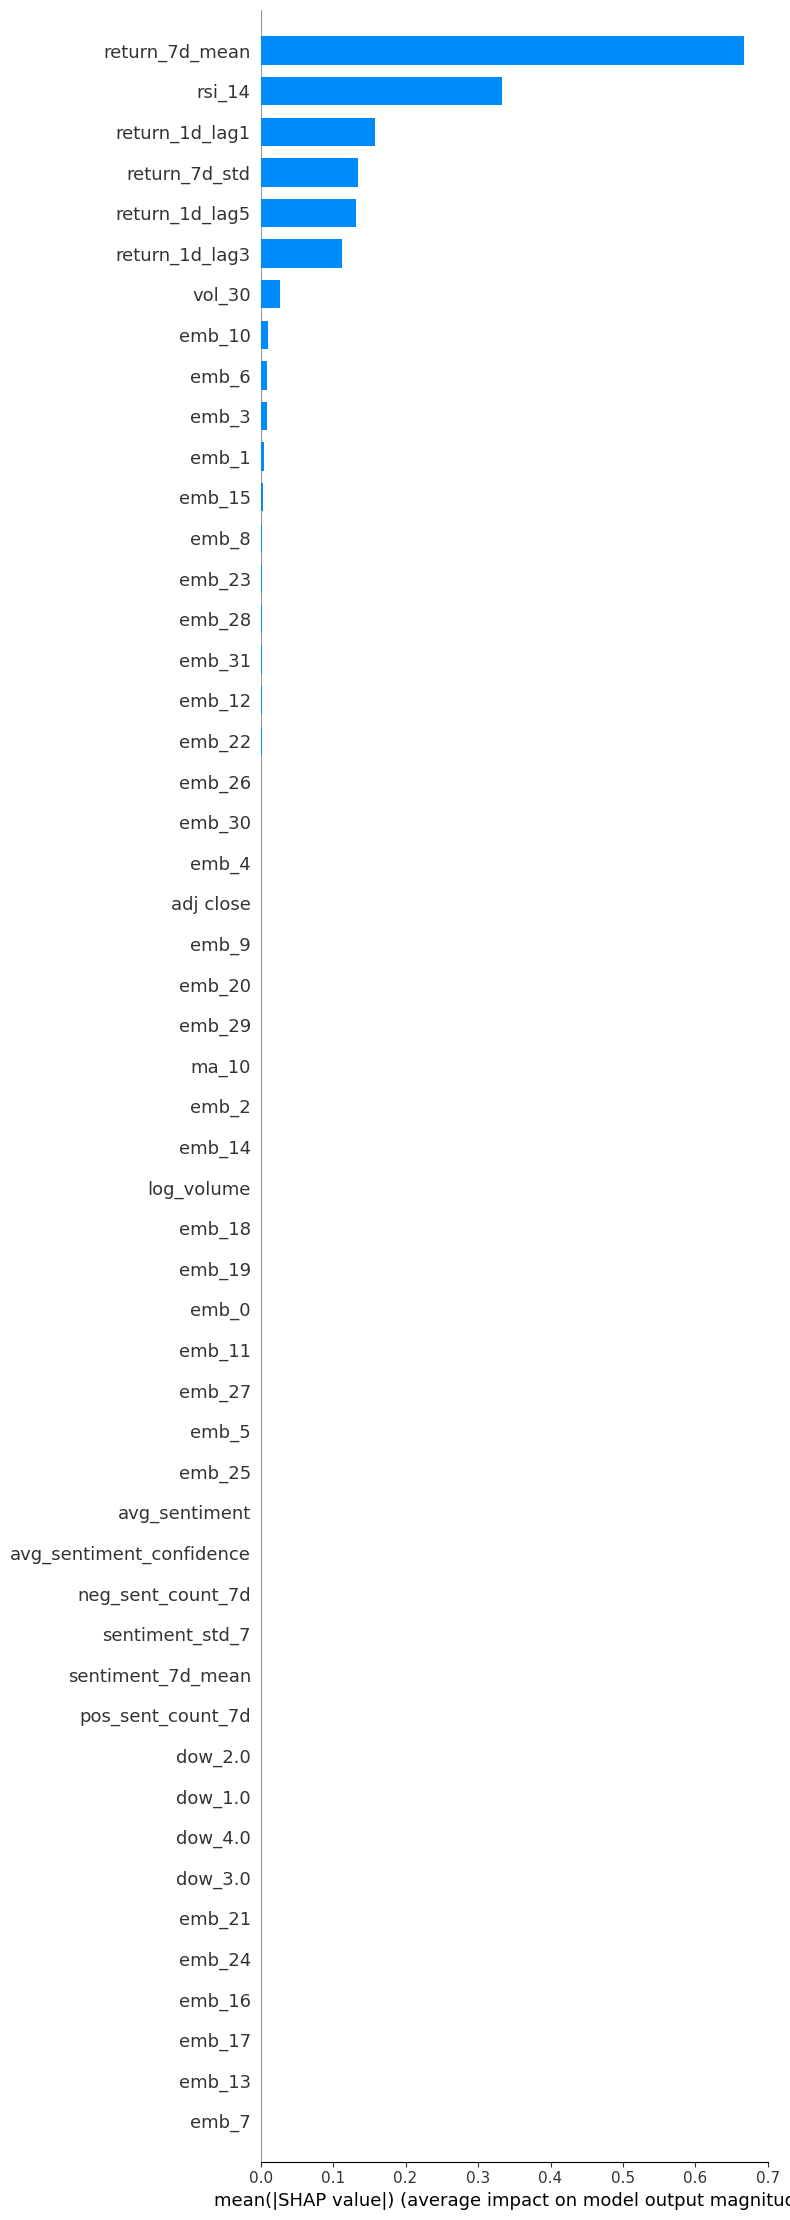

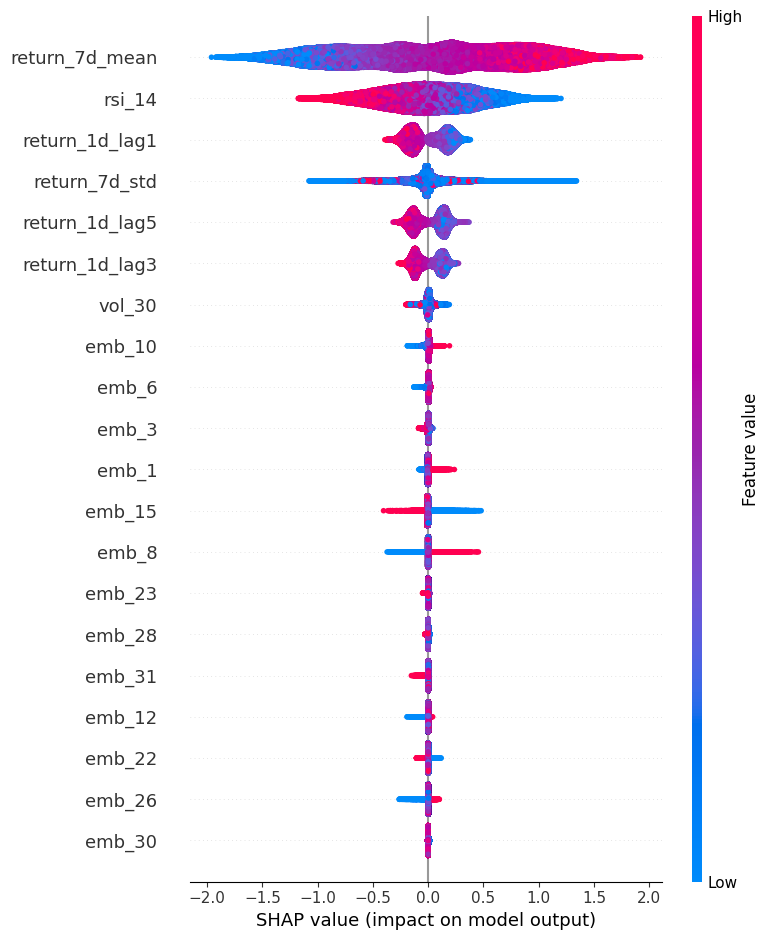


Permutation Importance (ΔF1) – Holdout Set:
return_7d_mean             ΔF1 = 0.2223  (+/-0.0004)
rsi_14                     ΔF1 = 0.0978  (+/-0.0005)
return_7d_std              ΔF1 = 0.0527  (+/-0.0004)
return_1d_lag1             ΔF1 = 0.0157  (+/-0.0003)
return_1d_lag5             ΔF1 = 0.0111  (+/-0.0003)
return_1d_lag3             ΔF1 = 0.0076  (+/-0.0003)
vol_30                     ΔF1 = 0.0005  (+/-0.0001)
emb_10                     ΔF1 = 0.0004  (+/-0.0001)
emb_3                      ΔF1 = 0.0003  (+/-0.0000)
emb_6                      ΔF1 = 0.0002  (+/-0.0000)
emb_30                     ΔF1 = 0.0001  (+/-0.0000)
emb_1                      ΔF1 = 0.0001  (+/-0.0000)
emb_2                      ΔF1 = 0.0000  (+/-0.0000)
emb_4                      ΔF1 = 0.0000  (+/-0.0000)
emb_0                      ΔF1 = 0.0000  (+/-0.0000)
adj close                  ΔF1 = 0.0000  (+/-0.0000)
emb_9                      ΔF1 = 0.0000  (+/-0.0000)
emb_11                     ΔF1 = 0.0000  (+/-0.0000)
e

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, GRU, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, brier_score_loss
)
import random
import warnings
import shap
from sklearn.inspection import permutation_importance

# Reproducibility & Load Data
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
warnings.filterwarnings("ignore")

file_path = '/content/drive/MyDrive/MRP/final_dataset.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
df = df.sort_values(['symbol', 'date']).reset_index(drop=True)

# Feature Engineering
# Multi-lag returns
for lag in (1, 3, 5):
    df[f'return_1d_lag{lag}'] = df.groupby('symbol')['return_1d'].shift(lag)

# Rolling-window return stats
df['return_7d_mean'] = df.groupby('symbol')['return_1d'].transform(lambda x: x.rolling(7).mean())
df['return_7d_std']  = df.groupby('symbol')['return_1d'].transform(lambda x: x.rolling(7).std())

# Rolling-window sentiment stats
df['sentiment_7d_mean'] = df.groupby('symbol')['avg_sentiment'].transform(lambda x: x.rolling(7).mean())
df['pos_sent_count_7d'] = df.groupby('symbol')['avg_sentiment']\
    .transform(lambda x: x.rolling(7).apply(lambda arr: (arr > 0).sum(), raw=True))
df['neg_sent_count_7d'] = df.groupby('symbol')['avg_sentiment']\
    .transform(lambda x: x.rolling(7).apply(lambda arr: (arr < 0).sum(), raw=True))

# One-hot encode day_of_week
dow_ohe = pd.get_dummies(df['day_of_week'], prefix='dow', drop_first=True)
df = pd.concat([df, dow_ohe], axis=1)

# Drop any NA from shifts/rolling windows
df = df.dropna().reset_index(drop=True)

# Build Sequence & Static Arrays
price_feats = ['adj close','log_volume','ma_10','vol_30','rsi_14','return_1d_lag1']
news_feats  = ['avg_sentiment','avg_sentiment_confidence','sentiment_std_7']
eng_feats   = [
    'return_1d_lag3','return_1d_lag5',
    'return_7d_mean','return_7d_std',
    'sentiment_7d_mean','pos_sent_count_7d','neg_sent_count_7d'
]
dow_feats   = [c for c in df.columns if c.startswith('dow_')]
static_feats = price_feats + news_feats + eng_feats + dow_feats
TARGET     = 'target'
SEQ_LEN    = 30

Xs, stat_X, ys, dates = [], [], [], []
for sym, grp in df.groupby('symbol'):
    grp = grp.sort_values('date').reset_index(drop=True)
    seq_vals  = grp[price_feats].values
    stat_vals = grp[static_feats].values
    lbls      = grp[TARGET].values
    dts       = grp['date'].values
    for i in range(SEQ_LEN, len(grp)):
        Xs.append(seq_vals[i-SEQ_LEN:i])
        stat_X.append(stat_vals[i])
        ys.append(lbls[i])
        dates.append(dts[i])

X        = np.stack(Xs).astype('float32')       # shape (N, SEQ_LEN, len(price_feats))
static_X = np.stack(stat_X).astype('float32')   # shape (N, len(static_feats))
y        = np.array(ys, dtype='float32')
dates    = np.array(dates)

# split into Train+Val (≤2022-12-31) vs Test (2023)
train_mask = dates <= np.datetime64('2022-12-31')
test_mask  = dates >  np.datetime64('2022-12-31')

X_train, X_test = X[train_mask], X[test_mask]
s_train, s_test = static_X[train_mask], static_X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Train samples: {len(y_train)}, Test samples: {len(y_test)}")

# Train CNN–BiLSTM–GRU Embedding Model on Full Training Set
inp = Input(shape=(SEQ_LEN, X_train.shape[2]))
x   = Conv1D(32, 3, padding='same', activation='relu')(inp)
x   = Conv1D(32, 3, padding='same', activation='relu')(x)
x   = Bidirectional(LSTM(64, return_sequences=True))(x)
x   = GRU(32)(x)
embed = Dropout(0.2)(x)
out   = Dense(1, activation='sigmoid')(embed)
seq_model = Model(inputs=inp, outputs=out)
seq_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)
seq_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=1024,
    callbacks=[EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)],
    verbose=2
)

# Extract Embeddings
embed_model = Model(inputs=inp, outputs=embed)
emb_train   = embed_model.predict(X_train, batch_size=1024)
emb_test    = embed_model.predict(X_test,  batch_size=1024)

# Train LightGBM on Hybrid Features
train_feat = np.hstack([emb_train, s_train])
test_feat  = np.hstack([emb_test,  s_test])

clf = lgb.LGBMClassifier(
    n_estimators=200,
    num_leaves=127,
    min_data_in_leaf=20,
    learning_rate=0.01,
    random_state=SEED,
    n_jobs=-1,
    verbosity=-1
)
clf.fit(train_feat, y_train)

# Reconstruct feature names to match test_feat columns
# emb_test.shape == (n_samples, emb_dim)
emb_dim       = emb_test.shape[1]
emb_names     = [f"emb_{i}" for i in range(emb_dim)]

# static_feats is the list we used to build static_X
# (price_feats + news_feats + eng_feats + dow_feats)
feature_names = emb_names + static_feats

assert test_feat.shape[1] == len(feature_names), \
       f"Got {test_feat.shape[1]} columns but {len(feature_names)} names"

# Compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_out  = explainer.shap_values(test_feat)

# for binary classifiers, shap_out is [shap0, shap1]; we want the "up" class
shap_vals = shap_out[1] if isinstance(shap_out, list) else shap_out
# shap_vals.shape == (n_samples, n_features)

# Global feature‐importance via mean(|SHAP|)
shap.summary_plot(
    shap_vals,
    test_feat,
    feature_names=feature_names,
    plot_type="bar",
    max_display=len(feature_names)
)

# Beeswarm of top 20 for more nuance
shap.summary_plot(
    shap_vals,
    test_feat,
    feature_names=feature_names,
    plot_type="dot",
    max_display=20
)

# Permutation importance (F1) for all features
perm = permutation_importance(
    clf,
    test_feat,
    y_test,
    scoring="f1",
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

# Pair (name, ΔF1_mean, F1_std) and sort descending
feat_imp = sorted(
    zip(feature_names, perm.importances_mean, perm.importances_std),
    key=lambda x: -x[1]
)

print("\nPermutation Importance (ΔF1) – Holdout Set:")
for name, mean_imp, std_imp in feat_imp:
    print(f"{name:25s}  ΔF1 = {mean_imp:.4f}  (+/-{std_imp:.4f})")

# Evaluate on 2023 Hold-out with τ=0.35
y_prob = clf.predict_proba(test_feat)[:, 1]
y_pred = (y_prob >= 0.35).astype(int)

print("\nFinal Hold-out (2023) Performance:")
print(f"  Accuracy    : {accuracy_score(y_test, y_pred):.4f}")
print(f"  Precision   : {precision_score(y_test, y_pred):.4f}")
print(f"  Recall      : {recall_score(y_test, y_pred):.4f}")
print(f"  F1 Score    : {f1_score(y_test, y_pred):.4f}")
print(f"  ROC AUC     : {roc_auc_score(y_test, y_prob):.4f}")
print(f"  Brier Score : {brier_score_loss(y_test, y_prob):.4f}")
print("  Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))